# Day4 強化学習に対するニューラルネットワークの適用

## TODO: Tensorboardを使った可視化

## DQN ~ CNNを使う ~

* DQNのキモ?
  * Experience Replay: 行動履歴を保存し、さまざまなエピソードから異なる時点の状態を同じミニバッチの学習データに使用する
  * Fixed Target Q-Network: 学習最中のモデルから遷移先の価値を計算するのではなく、一定期間固定されたパラメータから算出する
  * Clipping: 報酬を全ゲームを通じて、成功を1, 失敗を-1に統一する

* CNNは6層
  * conv:    8×8のフィルタを32枚, ストライド4, paddingは入力画像と出力画像が同じになるように, 活性化関数 ReLU
  * conv:    4×4のフィルタを64枚, ストライド2, paddingは入力画像と出力画像が同じになるように, 活性化関数 ReLU
  * conv:    3×3のフィルタを64枚, ストライド2`, paddingは入力画像と出力画像が同じになるように, 活性化関数 ReLU
  * flatten: 画像の形をしたデータを１列のベクトルにする
  * Dense:   出力するベクトルの次元を256次元に, 活性化関数 ReLU
  * Dense:   出力するベクトルの次元は行動の数と同じに

## tensorflowでgpuを使う場合
一度, tensorflowはuninstallし、tensorflow-gpuをinstallする

```sh
$ pip uninstall tensorflow tensorflow-estimator
$ pip install tensorflow-gpu==1.14.0
```

In [1]:
#TensorFlowがGPUを認識しているか確認
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-11-16 15:09:11.150305: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-11-16 15:09:11.190797: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-11-16 15:09:11.195345: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55eca1910f60 executing computations on platform Host. Devices:
2022-11-16 15:09:11.195384: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-11-16 15:09:11.197516: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2022-11-16 15:09:11.648796: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55eca2a28440 executing computations on platform CUDA. Devices:
2022-11-16 15:09:11.648827: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Tesla V100-PC

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10512527698961013960,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5748009229928437432
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12996586791841833867
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11081020651999653226
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6342700601535540895
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12025106470780680473
 physical_device_desc: "device: XLA_GPU device"

In [2]:
import tensorflow as tf
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="3", # specify GPU number
        allow_growth=True
    )
)
sess = tf.Session(config=config)

2022-11-16 15:09:11.683880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:89:00.0
2022-11-16 15:09:11.684016: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-16 15:09:11.684067: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-16 15:09:11.684110: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcufft.so.10.0'; dlerror: libcufft.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/l

In [3]:
import random
import argparse
from collections import deque
import numpy as np
from tensorflow.python import keras as K
from PIL import Image

import gym
import gym_ple

import sys
sys.path.append("../FN")
from fn_framework import FNAgent, Trainer, Observer

import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display

class DeepQNetworkAgent(FNAgent):

    def __init__(self, epsilon, actions):
        super().__init__(epsilon, actions)
        self._scaler = None
        self._teacher_model = None

    def initialize(self, experiences, optimizer):
        """モデルの構築"""
        # 入力の形状取得(今回であれば画像のサイズ?)
        feature_shape = experiences[0].s.shape
        self.make_model(feature_shape)
        self.model.compile(optimizer, loss="mse")
        self.initialized = True
        print("Done initialization. From now, begin training!")

    def make_model(self, feature_shape):
        """モデルの作成"""
        normal = K.initializers.glorot_normal()
        model = K.Sequential()
        model.add(K.layers.Conv2D(
            32, kernel_size=8, strides=4, padding="same",
            input_shape=feature_shape, kernel_initializer=normal,
            activation="relu"))
        model.add(K.layers.Conv2D(
            64, kernel_size=4, strides=2, padding="same",
            kernel_initializer=normal,
            activation="relu"))
        model.add(K.layers.Conv2D(
            64, kernel_size=3, strides=1, padding="same",
            kernel_initializer=normal,
            activation="relu"))
        model.add(K.layers.Flatten())
        model.add(K.layers.Dense(256, kernel_initializer=normal,
                                 activation="relu"))
        model.add(K.layers.Dense(len(self.actions),
                                 kernel_initializer=normal))
        self.model = model
        self._teacher_model = K.models.clone_model(self.model)

    def estimate(self, state):
        return self.model.predict(np.array([state]))[0]

    def update(self, experiences, gamma):
        states = np.array([e.s for e in experiences])
        n_states = np.array([e.n_s for e in experiences])

        estimateds = self.model.predict(states)
        # MLPの時とは違い、一定期間固定されたDQNから計算
        # 学習の安定につながる
        future = self._teacher_model.predict(n_states)

        for i, e in enumerate(experiences):
            reward = e.r
            if not e.d:
                reward += gamma * np.max(future[i])
            estimateds[i][e.a] = reward

        loss = self.model.train_on_batch(states, estimateds)
        return loss
    # Networkの更新
    def update_teacher(self):
        self._teacher_model.set_weights(self.model.get_weights())
        
    # jupyter labで描画させるためにoverlap    
    def play(self, env, episode_count=5, render=True):
        action_dic = {0: "neutral", 1: "right", 2: "left"}
        for e in range(episode_count):
            s = env.reset()
            done = False
            episode_reward = 0
            cnt = 0
            get_num = 0
            play_num = 1
            while not done:
                # 毎回レンダリングすると遅くなるので最初の50回は毎回レンダリングし、その後は50回おきにする
                if render and (cnt <= 50):
                    env.render()
                elif render and (cnt % 50 == 0) and (cnt > 50): 
                    env.render()
                a = self.policy(s)
                n_state, reward, done, info = env.step(a)
                if reward == 1:
                    get_num += 1
                if reward != 0:
                    play_num += 1
                plt.title(f"episode={e}, action={action_dic[a]}, done={done}, frame={cnt}, get={get_num}, play={play_num}")
                episode_reward += reward
                s = n_state
                cnt += 1
            else:
                print("Get reward {}.".format(episode_reward))

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


code 4-16 CartPoleでテストするためのクラス  
学習のプロセスが入っているmake_modelは時間がかかるため、それ以外の部分

In [4]:
class DeepQNetworkAgentTest(DeepQNetworkAgent):

    def __init__(self, epsilon, actions):
        super().__init__(epsilon, actions)

    def make_model(self, feature_shape):
        normal = K.initializers.glorot_normal()
        model = K.Sequential()
        model.add(K.layers.Dense(64, input_shape=feature_shape, kernel_initializer=normal, activation="relu"))
        model.add(K.layers.Dense(len(self.actions), kernel_initializer=normal, activation="relu"))
        self.model = model
        self._teacher_model = K.models.clone_model(self.model)

code 4-17 Observer定義  

時系列に並んだ4つの画面フレームを入力とするため、4フレームをまとめる処理を行う

In [5]:
class CatcherObserver(Observer):

    def __init__(self, env, width, height, frame_count):
        super().__init__(env)
        self.width = width
        self.height = height
        self.frame_count = frame_count
        self._frames = deque(maxlen=frame_count)

    def transform(self, state):
        grayed = Image.fromarray(state).convert("L")
        resized = grayed.resize((self.width, self.height))
        resized = np.array(resized).astype("float")
        normalized = resized / 255.0  # scale to 0~1
        if len(self._frames) == 0:
            for i in range(self.frame_count):
                self._frames.append(normalized)
        else:
            self._frames.append(normalized)
        feature = np.array(self._frames)
        # Convert the feature shape (f, w, h) => (h, w, f).
        feature = np.transpose(feature, (1, 2, 0))

        return feature
    
    # jupyter labで描画させるためにoverlap
    def render(self):
        # self._env.render(mode="rgb_array")
        plt.imshow(self._env.render(mode="rgb_array"))
        display.display(plt.gcf())
        display.clear_output(wait=True)

code4-18 Trainerの定義

In [6]:
class DeepQNetworkTrainer(Trainer):

    def __init__(self, buffer_size=50000, batch_size=32,
                 gamma=0.99, initial_epsilon=0.5, final_epsilon=1e-3,
                 learning_rate=1e-3, teacher_update_freq=3, report_interval=10,
                 log_dir="", file_name=""):
        super().__init__(buffer_size, batch_size, gamma,
                         report_interval, log_dir)
        self.file_name = file_name if file_name else "dqn_agent.h5"
        self.initial_epsilon = initial_epsilon
        self.final_epsilon = final_epsilon
        self.learning_rate = learning_rate
        self.teacher_update_freq = teacher_update_freq
        self.loss = 0
        self.training_episode = 0
        self._max_reward = -10

    def train(self, env, episode_count=1200, initial_count=200,
              test_mode=False, render=False, observe_interval=100):
        actions = list(range(env.action_space.n))
        if not test_mode:
            agent = DeepQNetworkAgent(1.0, actions)
        else:
            agent = DeepQNetworkAgentTest(1.0, actions)
            observe_interval = 0
        self.training_episode = episode_count

        self.train_loop(env, agent, episode_count, initial_count, render,
                        observe_interval)
        return agent

    def episode_begin(self, episode, agent):
        self.loss = 0

    def begin_train(self, episode, agent):
        optimizer = K.optimizers.Adam(lr=self.learning_rate, clipvalue=1.0)
        agent.initialize(self.experiences, optimizer)
        self.logger.set_model(agent.model)
        # epsilonを減衰して、ランダムな行動をしないようにしている
        agent.epsilon = self.initial_epsilon
        self.training_episode -= episode

    def step(self, episode, step_count, agent, experience):
        if self.training:
            batch = random.sample(self.experiences, self.batch_size)
            self.loss += agent.update(batch, self.gamma)

    def episode_end(self, episode, step_count, agent):
        """報酬や誤差(Loss)を記録し、学習途中でモデル保存"""
        reward = sum([e.r for e in self.get_recent(step_count)])
        self.loss = self.loss / step_count
        self.reward_log.append(reward)
        if self.training:
            self.logger.write(self.training_count, "loss", self.loss)
            self.logger.write(self.training_count, "reward", reward)
            self.logger.write(self.training_count, "epsilon", agent.epsilon)
            if reward > self._max_reward:
                agent.save(self.logger.path_of(self.file_name))
                self._max_reward = reward
            if self.is_event(self.training_count, self.teacher_update_freq):
                agent.update_teacher()

            diff = (self.initial_epsilon - self.final_epsilon)
            decay = diff / self.training_episode
            agent.epsilon = max(agent.epsilon - decay, self.final_epsilon)

        if self.is_event(episode, self.report_interval):
            recent_rewards = self.reward_log[-self.report_interval:]
            self.logger.describe("reward", recent_rewards, episode=episode)

code 4-19 実際に学習を行う

catcherゲームの定義 ([参考](https://kiyosucyberclub.web.fc2.com/KerasPage09-02.html))
* ライフが3与えられる
* doneになるのはゲームオーバーになったとき -> 3回ボール落とした時
* 報酬
    * バーに当たる(ボールをキャッチ): 1点
    * 捕まえられない かつ ライフに残りあり: -1
    * 捕まえられない かつ ライフがない (ゲームオーバー): -6

In [7]:
def main(play, is_test):
    file_name = "dqn_agent.h5" if not is_test else "dqn_agent_test.h5"
    trainer = DeepQNetworkTrainer(file_name=file_name)
    path = trainer.logger.path_of(trainer.file_name)
    agent_class = DeepQNetworkAgent

    if is_test:
        print("Train on test mode")
        obs = gym.make("CartPole-v0")
        agent_class = DeepQNetworkAgentTest
    else:
        env = gym.make("Catcher-v0")
        obs = CatcherObserver(env, 80, 80, 4)
        trainer.learning_rate = 1e-4

    if play:
        agent = agent_class.load(obs, path)
        agent.play(obs, episode_count=1, render=True)
    else:
        trainer.train(obs, test_mode=is_test)

なんだか右端に待機しすぎでは...？  
描画のタイミングとtitleがずれてる?

Get reward 56.0.


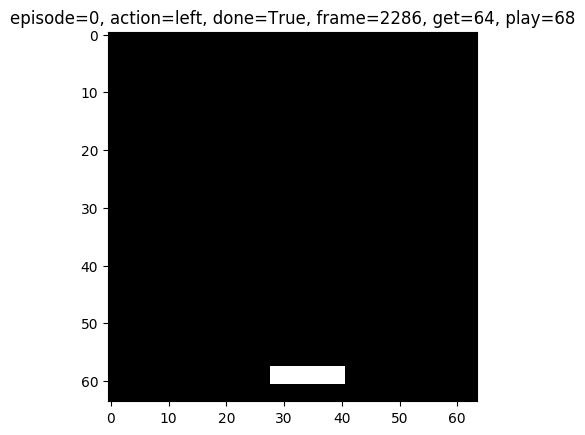

In [8]:
parser = argparse.ArgumentParser(description="DQN Agent")
parser.add_argument("--play", action="store_true",
                    help="play with trained model")
parser.add_argument("--test", action="store_true",
                    help="train by test mode")

args = parser.parse_args(args=["--play"])
main(args.play, args.test)

なぜreward 56?  
reward = 64 * 1 - 1 * 2 - 6 = 56